# Station Clustering (Summer 2018, weekend)
This notebook uses K-means clustering with PCA to group stations into 3 and 4 different clusters. 

The station features are the total hourly 'Activity' and 'Flux' where: 

    Activity = num_pickups + num_dropoffs

    Flux = num_pickups - num_dropoffs

In [3]:
%matplotlib inline 
#%matplotlib inline notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import requests
import math
from matplotlib import cm

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

In [4]:
###
subs_df = pd.read_pickle('../../data/pickledDFs/subs_df-NYC_Summer_2018.pkl')
stations_info_df = pd.read_pickle('../../data/pickledDFs/stations_info_df-NYC_Summer_2018.pkl')
subs_trips_df = pd.read_pickle('../../data/pickledDFs/subs_trips_df-NYC_Summer_2018.pkl')
###

In [4]:
#Number of weekend days and weekday days for Jan - March 2018
#num_WE = 25
#num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

In [6]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [7]:
#Need to filter out stations in stations_info_df that do not appear in weekend_subs_trips
station_drops = []
WE_unique = np.unique(np.concatenate((weekend_subs_trips_df['start station id'].unique(),weekend_subs_trips_df['end station id'].unique())))

for ind in stations_info_df.index:
    if not (ind in WE_unique):
        station_drops.append(ind)
        
print(station_drops)

stations_info_df.drop(station_drops,inplace=True)
len(stations_info_df) == len(WE_unique)

[3036, 3240, 3485, 3683, 3704, 493, 3040, 3267, 3275, 3214, 3199, 3270, 3183, 3103, 3487, 3198, 3213, 3203, 3192, 3268]


True

In [8]:
WE_puhour_groupby = weekend_subs_trips_df.groupby(['start station id', 'pickup_hour'])
WE_puhour_df = WE_puhour_groupby.count()['tripduration'].rename('NumPickups').reset_index(1).pivot(columns = 'pickup_hour').fillna(0)

WE_dohour_groupby = weekend_subs_trips_df.groupby(['end station id', 'dropoff_hour'])
WE_dohour_df = WE_dohour_groupby.count()['tripduration'].rename('NumDropoffs').reset_index(1).pivot(columns = 'dropoff_hour').fillna(0)


In [9]:
WE_puhour_df.head()

NumPickups                                                 \
pickup_hour              0     1     2     3    4     5     6     7     8    
start station id                                                             
72                     32.0  28.0  38.0  10.0  6.0  22.0  31.0  50.0  89.0   
79                     30.0  17.0   8.0  10.0  0.0   0.0   6.0  16.0  22.0   
82                      6.0   3.0   5.0   1.0  2.0   1.0  32.0  14.0  20.0   
83                     19.0  16.0   8.0   6.0  3.0   2.0   7.0   7.0  16.0   
119                     0.0   0.0   2.0   0.0  0.0   0.0   3.0   5.0   7.0   

                        ...                                                    \
pickup_hour         9   ...      14     15     16     17     18     19     20   
start station id        ...                                                     
72                87.0  ...   173.0  181.0  166.0  168.0  187.0  129.0  112.0   
79                55.0  ...   103.0  105.0  120.0   98.0   88.0   66.0   60.0   
82                37.0  ...    46.0   58.0   55.0   46.0   45.0   38.0   34.0   
83                25.0  ...    86.0  106.0  102.0  121.0   93.0   86.0   63.0   
119               17.0  ...     7.0    7.0   17.0   16.0    8.0   12.0    8.0   

                                    
pickup_hour         21    22    23  
start station id                    
72                59.0  50.0  42.0  
79                48.0  40.0  34.0  
82                18.0  11.0  13.0  
83                51.0  51.0  40.0  
119               14.0   7.0   4.0  

[5 rows x 24 columns]

In [10]:
WE_counts_df = pd.concat([WE_puhour_df,WE_dohour_df],axis=1).fillna(0)
WE_counts_df['total_pickups'] = WE_counts_df['NumPickups'].sum(axis=1)
WE_counts_df['total_dropoffs'] = WE_counts_df['NumDropoffs'].sum(axis=1)

In [11]:
for num in range(24):
    WE_counts_df['Activity',num] =  WE_counts_df['NumPickups',num] + WE_counts_df['NumDropoffs',num]
    WE_counts_df['Flux',num] =  WE_counts_df['NumPickups',num] - WE_counts_df['NumDropoffs',num]

WE_counts_df['total_counts'] = WE_counts_df['Activity'].sum(axis=1)


In [12]:
WE_counts_df.sort_values('total_counts',ascending=False).head()

NumPickups                                                   \
pickup_hour          0     1     2     3     4     5     6     7      8   
497               68.0  40.0  20.0  11.0   4.0   5.0  20.0  53.0  122.0   
435               48.0  29.0  25.0  22.0   8.0   5.0  11.0  37.0  196.0   
285              127.0  69.0  42.0  22.0  18.0  10.0  24.0  62.0  121.0   
426               73.0  26.0  12.0   1.0   6.0  12.0  29.0  96.0  170.0   
368              153.0  91.0  63.0  53.0  23.0  11.0  37.0  73.0  137.0   

                       ...       Flux Activity  Flux Activity  Flux Activity  \
pickup_hour      9     ...         19       20    20       21    21       22   
497          207.0     ...       78.0    443.0  83.0    329.0  51.0    215.0   
435          287.0     ...       43.0    586.0  38.0    445.0  19.0    203.0   
285          216.0     ...       53.0    663.0  49.0    592.0  46.0    394.0   
426          252.0     ...      -28.0    612.0   4.0    453.0  61.0    306.0   
368          239.0     ...       -3.0    696.0 -82.0    575.0   5.0    450.0   

             Flux Activity  Flux total_counts  
pickup_hour    22       23    23               
497          69.0    127.0  25.0      13476.0  
435          13.0    116.0  -4.0      13269.0  
285          62.0    252.0  26.0      13264.0  
426           6.0    160.0 -12.0      12786.0  
368          46.0    302.0   2.0      12330.0  

[5 rows x 99 columns]

In [13]:
# What's the most popular station?
stations_info_df.loc[[519,497,402,435,426]] #Top one is Grand Central Station

lat        lon           station name
519  40.751873 -73.977706  Pershing Square North
497  40.737050 -73.990093     E 17 St & Broadway
402  40.740343 -73.989551     Broadway & E 22 St
435  40.741740 -73.994156        W 21 St & 6 Ave
426  40.717548 -74.013221  West St & Chambers St

In [14]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import seaborn as sns; sns.set()
def color_st(x):
    sns.set_color_codes()
    if x == 0:
        return 'b'
    elif x == 1:
        return 'orange'
    elif x == 2:
        return 'g'
    elif x == 3:
        return 'r'
    elif x == 4:
        return 'purple'
    elif x == 5:
        return 'm'
    elif x == 6:
        return 'c'
    elif x == 7:
        return 'y'
    

#Imported/modified from UMICH coursera course, a simple scatter plot function
def plot_labelled_scatter(X, y, class_labels, pca_vars = (0,1)):
    num_labels = len(class_labels)
    y_ser = pd.Series(y)

    x_min, x_max = X[:, pca_vars[0]].min() - 1, X[:, pca_vars[0]].max() + 1
    y_min, y_max = X[:, pca_vars[1]].min() - 1, X[:, pca_vars[1]].max() + 1

    marker_array = ['o', '^', '*']
    color_array = [color_st(num) for num in range(0,num_labels)]
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    
    plt.scatter(X[:, pca_vars[0]], X[:, pca_vars[1]], s=65, color=y_ser.map(lambda x: color_st(x)), norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_st(c), label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()
    
def plot_3d_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)
    y_ser = pd.Series(y)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1

    marker_array = ['o', '^', '*']
    color_array = [color_st(num) for num in range(0,num_labels)]
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.scatter(X[:, 0], X[:, 1],X[:, 2], s=65, color=y_ser.map(lambda x: color_st(x)), norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_st(c), label=class_labels[c]))
    plt.legend(handles=h)
    plt.legend()
    

In [15]:
import tilemapbase
tilemapbase.start_logging()

In [16]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [17]:
t = tilemapbase.tiles.Carto_Light

In [18]:
hour_mark_loc = (-74.02,40.77)
x_cen, y_cen = tilemapbase.project(*hour_mark_loc)

stations = [tilemapbase.project(x,y) for x,y in zip(stations_info_df['lon'], stations_info_df['lat'])]
x, y = zip(*stations)

# Clustering with Activity and Flux (3 clusters)

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = WE_counts_df[['Activity','Flux']].values

X_normalized = StandardScaler().fit(X).transform(X)

#Only compute the first two PCA components, going to higher order starts to be sensitive to local (hourly) structure of data
pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

print(X.shape, X_pca.shape)

(782, 48) (782, 2)


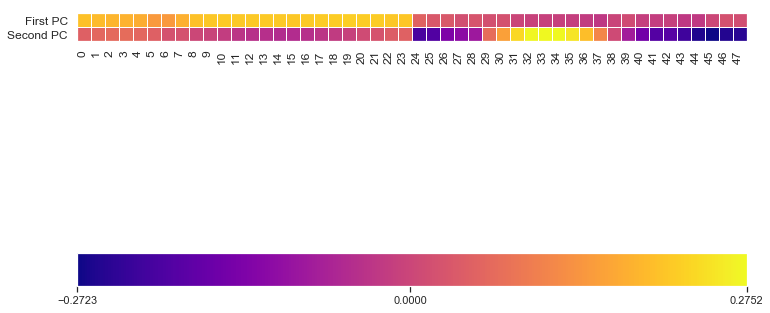

In [27]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')

plt.gca().set_xticks(np.arange(-.5, 48))
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(range(48), rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

In [28]:
print('First PCA mean norm and std dev of hourly activity coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[0][:24]).mean(),np.absolute(pca.components_[0][:24]).std()))
print('First PCA mean norm and std dev of hourly flux coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[0][24:]).mean(),np.absolute(pca.components_[0][24:]).std()))

print('Second PCA mean norm and std dev of hourly activity coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[1][:24]).mean(),np.absolute(pca.components_[1][:24]).std()))
print('Second PCA mean norm and std dev hourly flux coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[1][24:]).mean(),np.absolute(pca.components_[1][24:]).std()))


First PCA mean norm and std dev of hourly activity coefficient: 0.202, 0.021
First PCA mean norm and std dev of hourly flux coefficient: 0.018, 0.012
Second PCA mean norm and std dev of hourly activity coefficient: 0.037, 0.020
Second PCA mean norm and std dev hourly flux coefficient: 0.186, 0.074


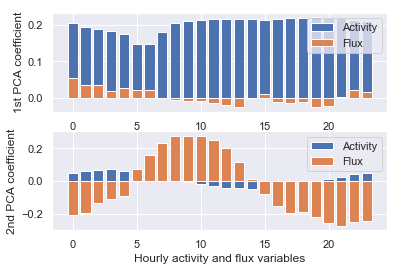

In [29]:
#Another visualization of the PCA components
fig,ax = plt.subplots(2)

ax[0].bar(range(24),pca.components_[0][:24])
ax[0].bar(range(24),pca.components_[0][24:])
ax[0].set_xlabel('Hourly activity and flux variables')
ax[0].set_ylabel('1st PCA coefficient')

ax[0].legend(['Activity','Flux'])

ax[1].bar(range(24),pca.components_[1][:24])
ax[1].bar(range(24),pca.components_[1][24:])
ax[1].set_xlabel('Hourly activity and flux variables')
ax[1].set_ylabel('2nd PCA coefficient')

ax[1].legend(['Activity','Flux'])

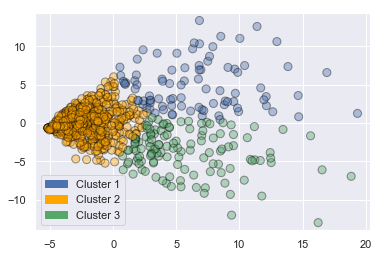

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3)
kmeans.fit(X_pca)

WE_counts_df['Kmeans_label'] = kmeans.labels_

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])

In [31]:
flux_df=WE_counts_df[['Flux','Kmeans_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
flux_melt_df = flux_df.iloc[0:24].melt('hour', var_name='station', value_name='flux')
flux_melt_df['Kmeans_label']=flux_melt_df['station'].map(lambda x: flux_df.iloc[24][x])

In [32]:
flux_melt_df['Kmeans_label']=flux_melt_df['Kmeans_label'].astype(int)

In [33]:
flux_melt_df.head()

hour station  flux  Kmeans_label
0    0      72  16.0             0
1    1      72  11.0             0
2    2      72  23.0             0
3    3      72   3.0             0
4    4      72   0.0             0

C:\Users\pgsze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


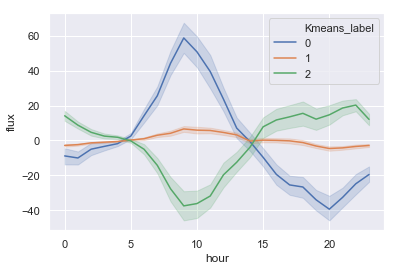

In [34]:
#Using Flux 
sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="flux", hue = 'Kmeans_label', palette = sns.color_palette(n_colors=3),data=flux_melt_df)

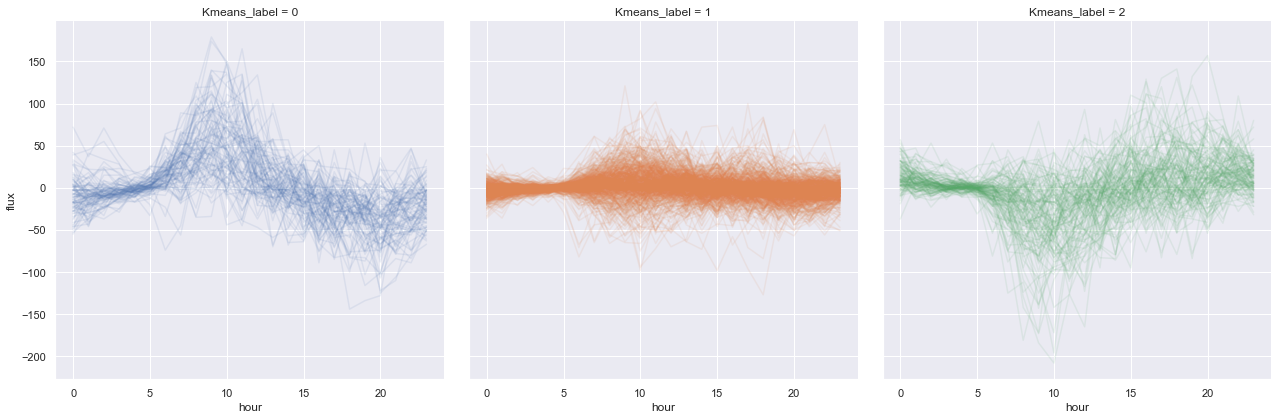

In [35]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(flux_melt_df,col='Kmeans_label',hue='Kmeans_label', hue_order=[0,1,2], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

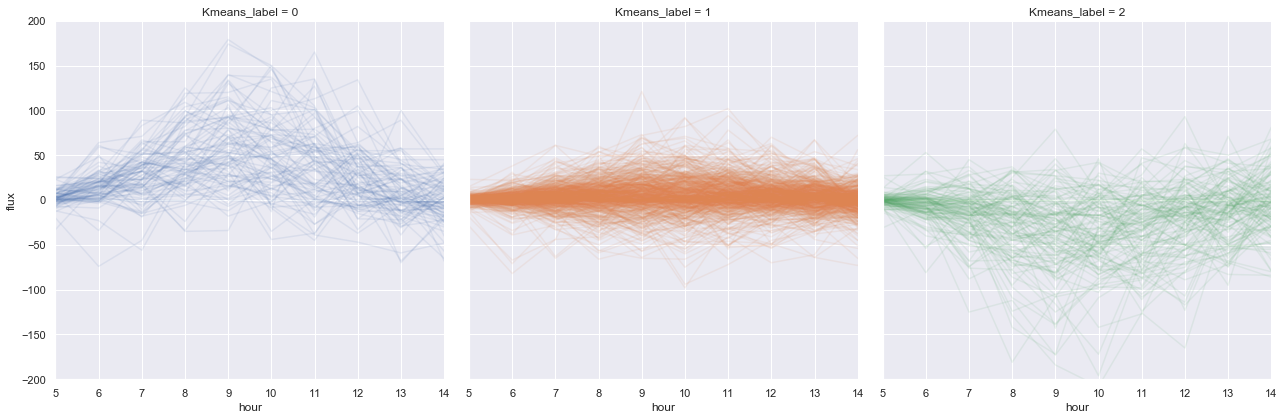

In [38]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_melt_df,col='Kmeans_label',hue='Kmeans_label', height=6,col_wrap=3)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-200, top=200);
ax.set_xlim(left=5,right=14);

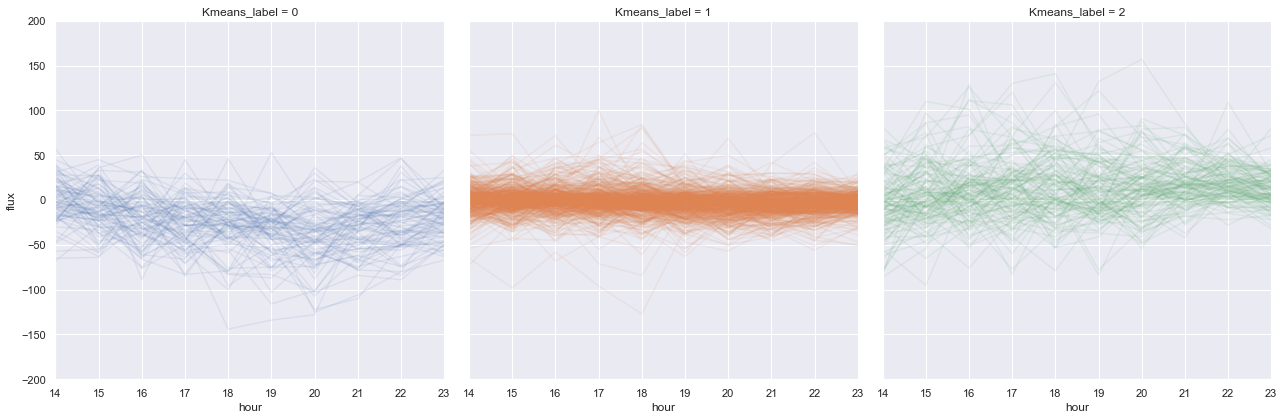

In [39]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_melt_df,col='Kmeans_label',hue='Kmeans_label', height=6,col_wrap = 3)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-200, top=200);
ax.set_xlim(left=14,right=23);

Plotting Activity

In [40]:
activity_df=WE_counts_df[['Activity','Kmeans_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
activity_melt_df = activity_df.iloc[0:24].melt('hour', var_name='station', value_name='activity')
activity_melt_df['Kmeans_label']=activity_melt_df['station'].map(lambda x: activity_df.iloc[24][x])

In [41]:
activity_melt_df['Kmeans_label']=activity_melt_df['Kmeans_label'].astype(int)

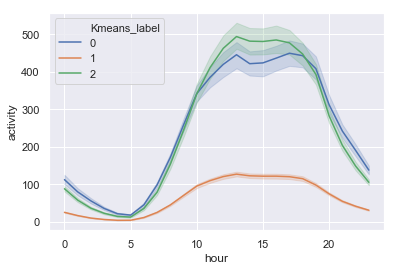

In [42]:
sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="activity", hue = 'Kmeans_label', palette = sns.color_palette(n_colors=3),data=activity_melt_df)

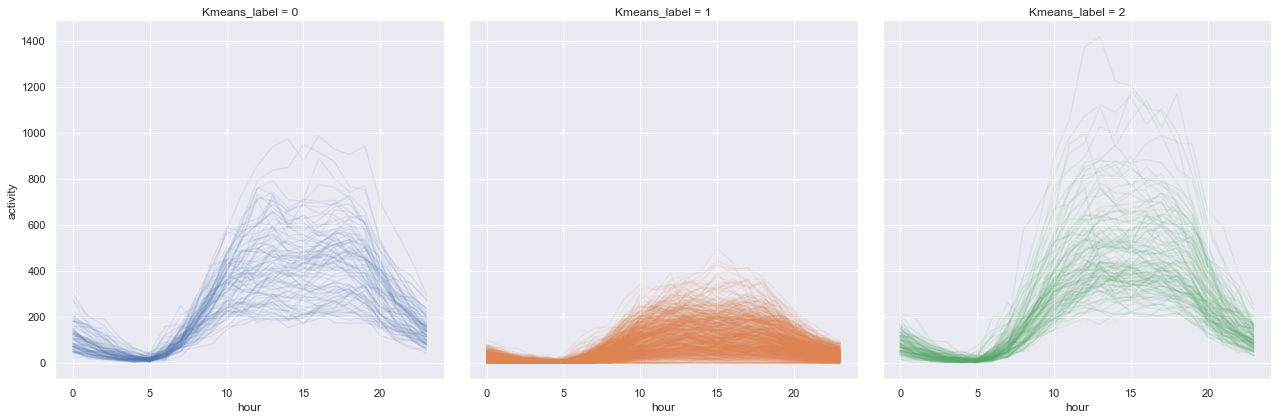

In [43]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(activity_melt_df,col='Kmeans_label',hue='Kmeans_label', hue_order=[0,1,2], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','activity', estimator = None, units='station',alpha=.1)

In [44]:
for num in range(len(np.unique(kmeans.labels_))):
    print('Kmeans_label {}: {}'.format(num,len(WE_counts_df[WE_counts_df['Kmeans_label'] == num])))

Kmeans_label 0: 88
Kmeans_label 1: 569
Kmeans_label 2: 125


In [79]:
stations_info_df['Kmeans_label'] = WE_counts_df['Kmeans_label']
stations_info_df['color'] = stations_info_df['Kmeans_label'].map(lambda x: color_st(x))

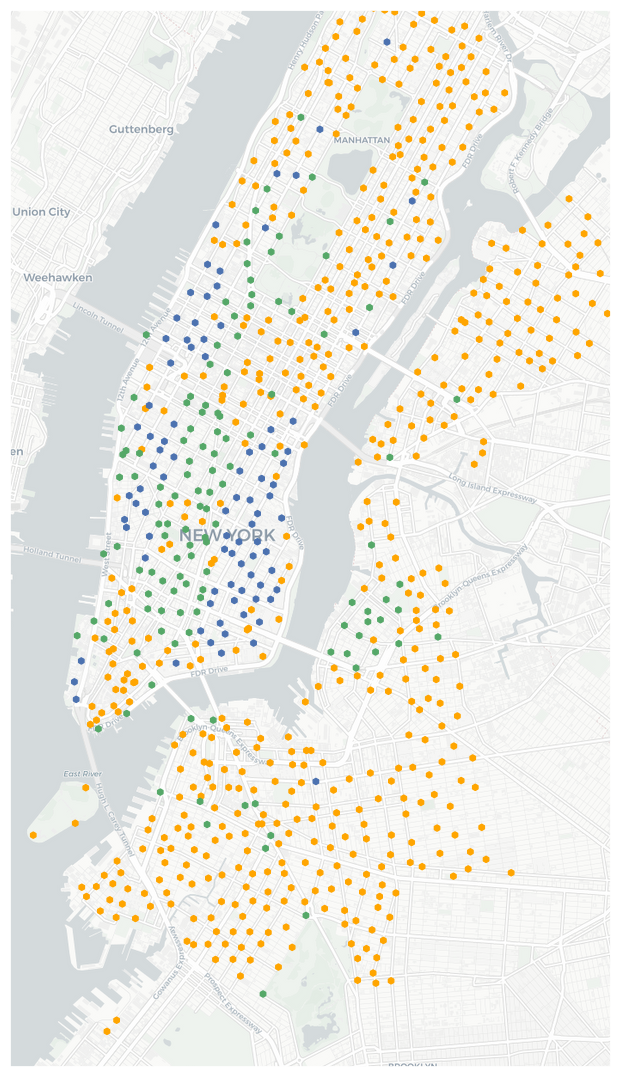

In [46]:
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)

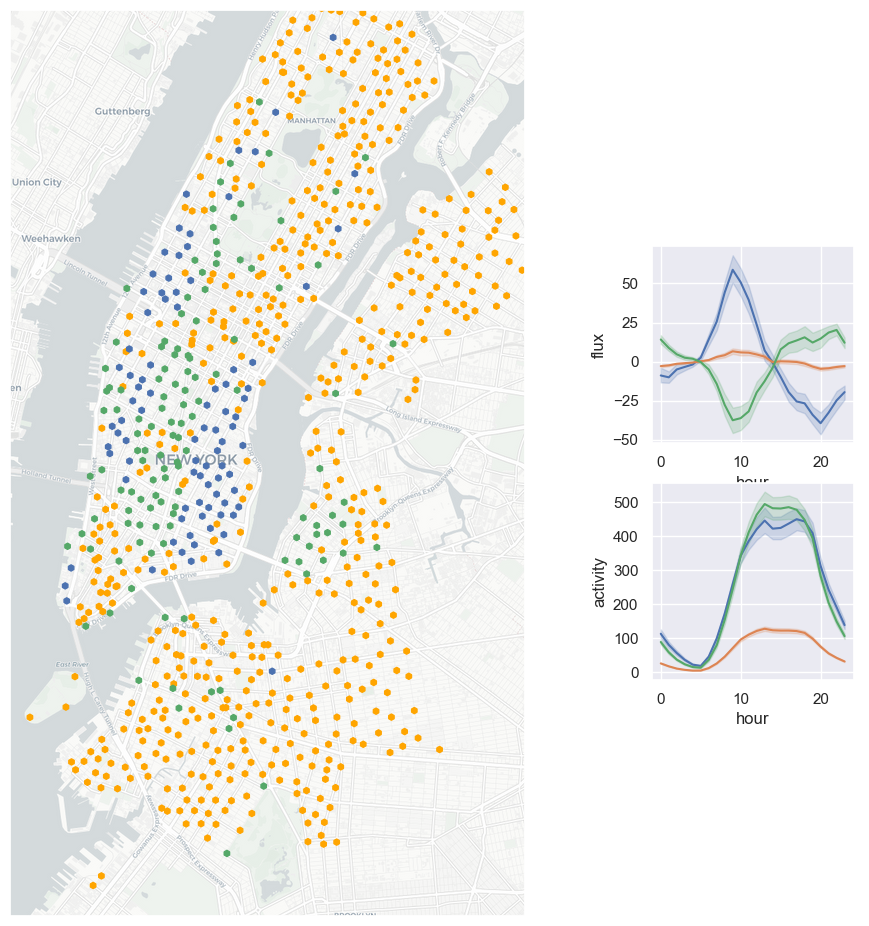

In [81]:
#fig, ax = plt.subplots(figsize=(12,12), dpi=100)
fig = plt.subplots(figsize=(12,12),dpi=100)
    
ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=4,colspan=3)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax1, t)

ax1.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)#, animated=True);

ax2 =  plt.subplot2grid((4, 4), (1, 3))
sns.lineplot(x="hour", y="flux", hue = 'Kmeans_label', palette = sns.color_palette(n_colors = 3), data=flux_melt_df,legend=False)


ax3 =  plt.subplot2grid((4, 4), (2, 3))
sns.lineplot(x="hour", y="activity", hue = 'Kmeans_label', palette = sns.color_palette(n_colors = 3), data=activity_melt_df,legend=False)

## Now using 4 clusters

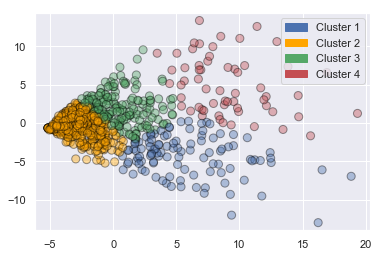

In [84]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

kmeans4 = KMeans(n_clusters = 4)
kmeans4.fit(X_pca)

plot_labelled_scatter(X_pca, kmeans4.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4'])

In [85]:
WE_counts_df['Kmeans4_label'] = kmeans4.labels_

Plotting Flux

In [86]:
flux_4cluster_df=WE_counts_df[['Flux','Kmeans4_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
flux_4cluster_melt_df = flux_4cluster_df.iloc[0:24].melt('hour', var_name='station', value_name='flux')
flux_4cluster_melt_df['Kmeans4_label']=flux_4cluster_melt_df['station'].map(lambda x: flux_4cluster_df.iloc[24][x])

In [87]:
flux_4cluster_melt_df['Kmeans4_label']=flux_4cluster_melt_df['Kmeans4_label'].astype(int)

C:\Users\pgsze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


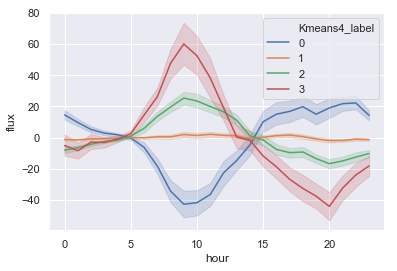

In [88]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
sns.color_palette()

ax = sns.lineplot(x="hour", y="flux", hue = 'Kmeans4_label', palette = sns.color_palette(n_colors = 4), data=flux_4cluster_melt_df)

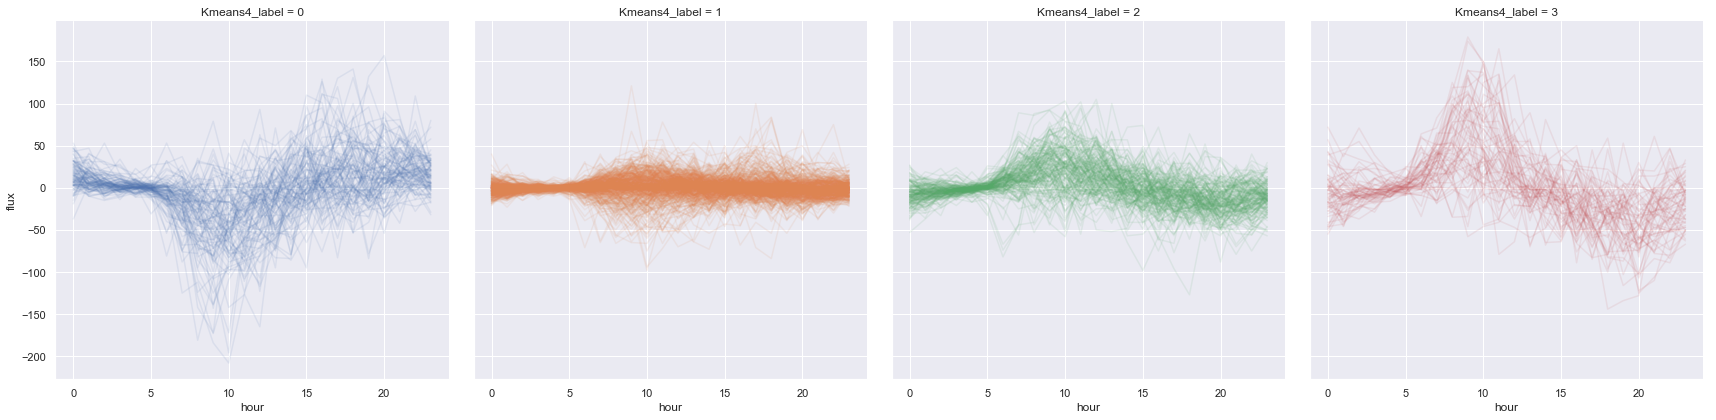

In [89]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap = 4)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

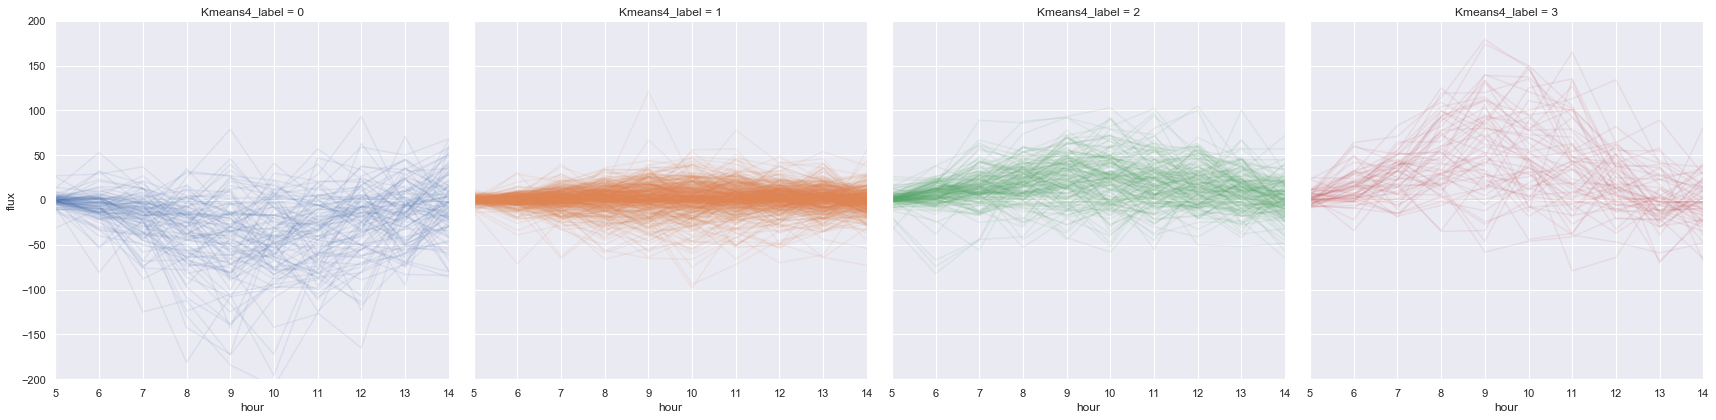

In [90]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap = 4)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-200, top=200);
ax.set_xlim(left=5,right=14);

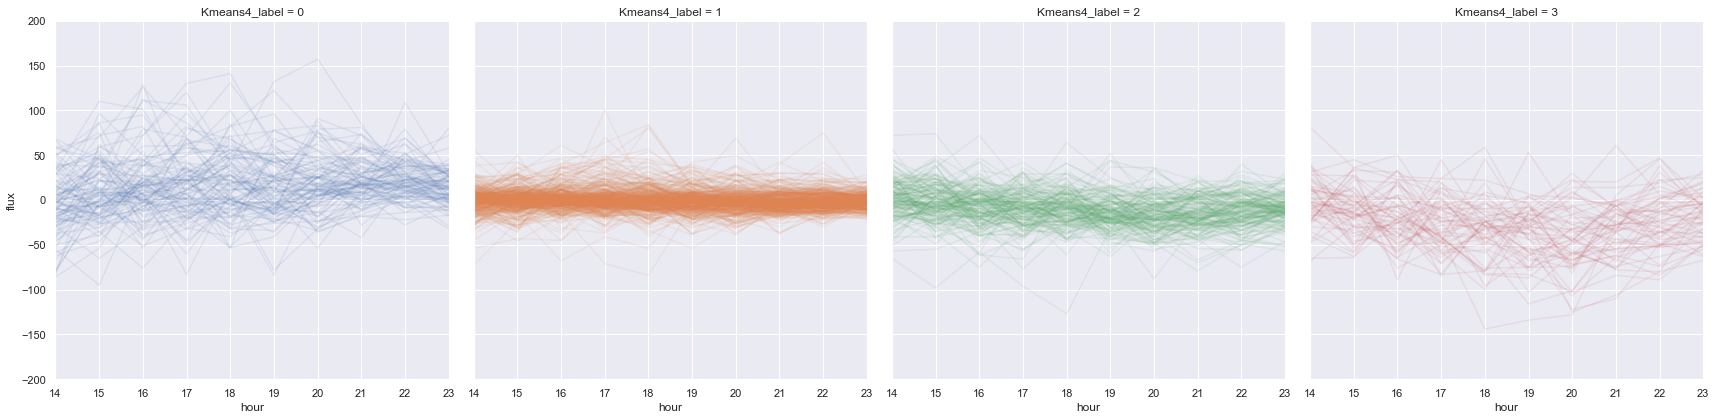

In [91]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap = 4)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-200, top=200);
ax.set_xlim(left=14,right=23);

Plotting Activity

In [92]:
activity_4cluster_df=WE_counts_df[['Activity','Kmeans4_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
activity_4cluster_melt_df = activity_4cluster_df.iloc[0:24].melt('hour', var_name='station', value_name='activity')
activity_4cluster_melt_df['Kmeans4_label']=activity_4cluster_melt_df['station'].map(lambda x: activity_4cluster_df.iloc[24][x])

In [93]:
activity_4cluster_melt_df['Kmeans4_label']=activity_4cluster_melt_df['Kmeans4_label'].astype(int)

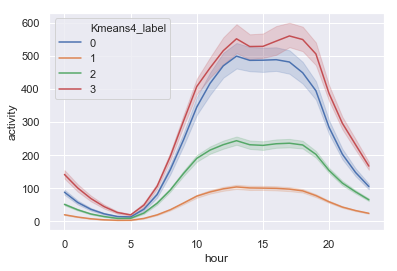

In [94]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="activity", hue = 'Kmeans4_label', palette= sns.color_palette(n_colors=4), data=activity_4cluster_melt_df)


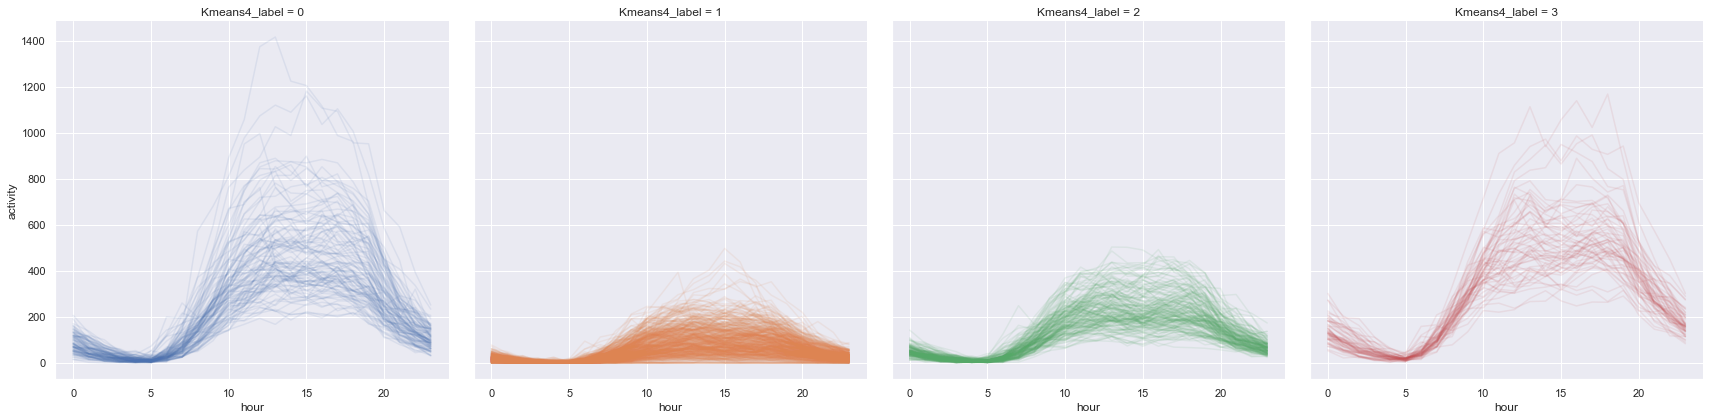

In [95]:
#Plot all stations
sns.set(font_scale=1)

g = sns.FacetGrid(activity_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap=4)
g = g.map_dataframe(sns.lineplot, 'hour','activity', estimator = None, units='station',alpha=.1)

In [96]:
for num in range(len(np.unique(kmeans4.labels_))):
    print('Kmeans4_label {}: {}'.format(num,len(WE_counts_df[WE_counts_df['Kmeans4_label'] == num])))

Kmeans4_label 0: 106
Kmeans4_label 1: 448
Kmeans4_label 2: 168
Kmeans4_label 3: 60


In [97]:
stations_info_df['Kmeans4_label'] = WE_counts_df['Kmeans4_label']
stations_info_df['color4'] = stations_info_df['Kmeans4_label'].map(lambda x: color_st(x))

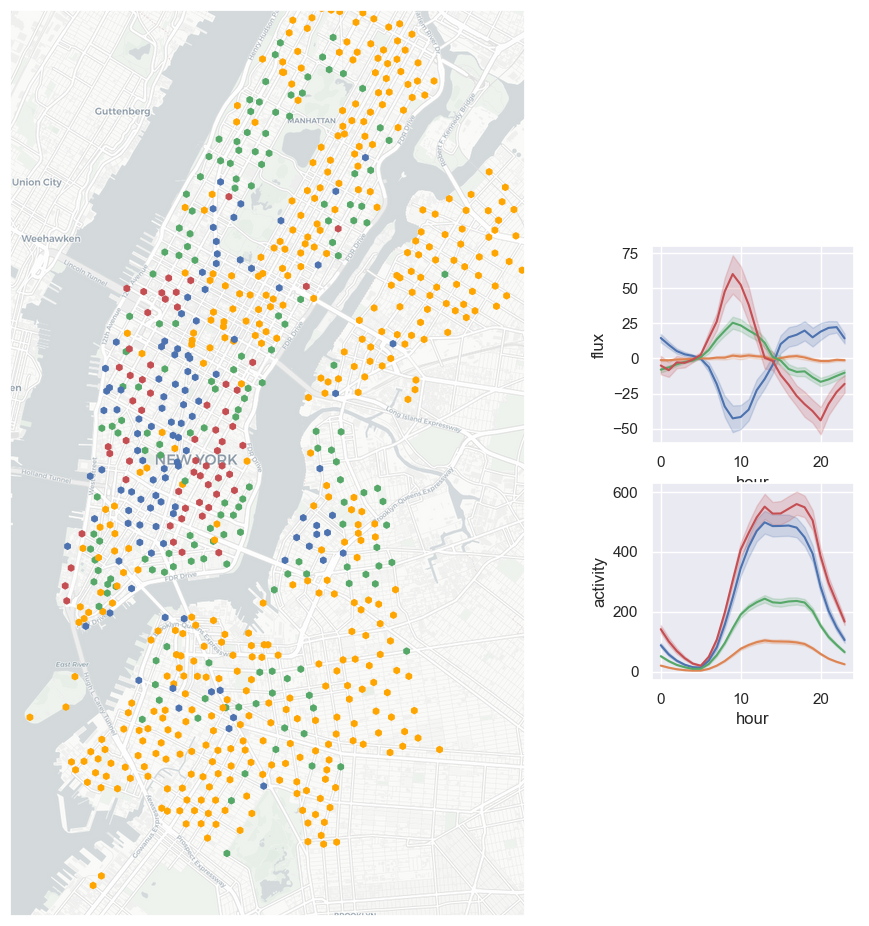

In [98]:
#fig, ax = plt.subplots(figsize=(12,12), dpi=100)
fig = plt.subplots(figsize=(12,12),dpi=100)
    
ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=4,colspan=3)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax1, t)

ax1.scatter(x,y, marker = 'h', color = stations_info_df['color4'], alpha = 1, s = 20)#, animated=True);

ax2 =  plt.subplot2grid((4, 4), (1, 3))
sns.lineplot(x="hour", y="flux", hue = 'Kmeans4_label', palette = sns.color_palette(n_colors = 4), data=flux_4cluster_melt_df,legend=False)


ax3 =  plt.subplot2grid((4, 4), (2, 3))
sns.lineplot(x="hour", y="activity", hue = 'Kmeans4_label', palette = sns.color_palette(n_colors = 4), data=activity_4cluster_melt_df,legend=False)

In [ ]:
#fig, ax = plt.subplots(figsize=(12,12), dpi=100)
#    
#ax.xaxis.set_visible(False)
#ax.yaxis.set_visible(False)
#
#plotter = tilemapbase.Plotter(extent, t, width=600)
#plotter.plot(ax, t)
#
#ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)#, animated=True);
#   